# Yet Another NY Taxi demo

In this notebook, we'll set up a connection to IRIS and walk through a few exciting query results

In [1]:
import iris, time
import pandas as pd

connection = iris.connect("localhost:51789/NYTAXI", "_SYSTEM", "SYS")

The following paragraph just suppresses usage warnings for pandas preferring SQLAlchemy over DB-API 

In [2]:
import warnings

# disable usage warning for pandas / DB-API
warnings.simplefilter("ignore")

Now we'll set up a few utility functions we'll be using throughout the demo

In [3]:
last_time = 0
last_grefs = 0

def brag(prev, new, speed=True):
    if ((prev == 0) or (new == 0) or (prev == new)):
        return ""
    if (prev > new):
        rate = prev / new
        s = "faster" if speed else "less"
        if (rate > 2):
            return " - "+str(round(rate,2))+"x "+s
        else:
            return " - "+str(round(rate*100-100,0))+"% "+s
    else:
        rate = new / prev
        s = "slower" if speed else "more"
        if (rate > 2):
            return " - "+str(round(rate,2))+"x "+s
        else:
            return " - "+str(round(rate*100-100,0))+"% "+s
        

def query(sql, compare = False):
    global last_time, last_grefs
    c1 = connection.cursor()
    c1.execute("SELECT NYTaxi.GloRefs()")
    start_grefs = c1.fetchall()[0][0]
    
    start_time = time.time()
    result = pd.read_sql(sql, connection)
    exec_time = time.time() - start_time
    
    c1.execute("SELECT NYTaxi.GloRefs()")
    exec_grefs = c1.fetchall()[0][0] - start_grefs - 1
    
    if compare:
        print("\nExecution time: "+str(round(exec_time,3))+"s " + brag(last_time, exec_time))
        print("Global references: "+str(exec_grefs)+" "+ brag(last_grefs, exec_grefs, False))
        last_time = exec_time
        last_grefs = exec_grefs
    else:
        print("\nExecution time: "+str(round(exec_time,3))+"s \nGlobal references: "+str(exec_grefs))
    return result


def reset_compare(sql, compare = False):
    global last_time, last_grefs
    last_time = 0
    last_grefs = 0

## A first test to validate the connection


Execution time: 1.223s 
Global references: 1248


<AxesSubplot:title={'center':'Query results'}, ylabel='pg'>

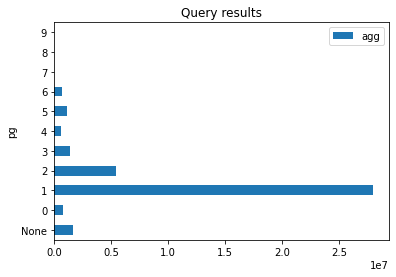

In [4]:
r = query("SELECT passenger_count AS pg, COUNT(*) AS agg FROM NYTaxi.Rides GROUP BY passenger_count")
r.plot.barh(x='pg',y='agg',title="Query results")

## Adaptive Mode in SQL

Adaptive Mode includes RunTime PlanChoice, which we can disable for the sake of the demo by using `#NORUNTIME`

In [ ]:
r = query("SELECT %NORUNTIME AVG(total_amount) "+
             "FROM NYTaxi.RowRides "+
             "WHERE passenger_count > 2 AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2021-12-31'", True)

In [ ]:
r = query("SELECT AVG(total_amount) "+
             "FROM NYTaxi.RowRides "+
             "WHERE passenger_count > 2 AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2021-12-31'", True)

The above speedup is realized by making proper use of advanced statistics collected by IRIS in 2022.1. In this particular case, we're relying on histograms that capture how our field values are distributed across rows. The chart below shows this information for the `tpep_pickup_datetime` field.

In [ ]:
r = query("SELECT BUCKET_POSITION, PERCENTILE, CAST((VALUE+1) AS POSIXTIME) AS VALUE "+
          "FROM INFORMATION_SCHEMA.COLUMN_HISTOGRAMS "+
          "WHERE TABLE_SCHEMA = 'NYTaxi' AND TABLE_NAME = 'RowRides' AND COLUMN_NAME = 'tpep_pickup_datetime'")
r.plot.bar(x='VALUE', y='PERCENTILE')

# Columnar Storage

Now let's run the very same query again, now targeting the columnar version of our table. 
Note the different table name in the `FROM` clause.

In [ ]:
r = query("SELECT %NORUNTIME AVG(total_amount) "+
             "FROM NYTaxi.Rides "+
             "WHERE passenger_count > 2 AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2021-12-31'", True)

That was just to show off, now let's look at some more decent examples